# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [358]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [359]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [360]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [361]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [362]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [363]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [364]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [365]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

In [366]:
print(X_tr.shape, y_tr.shape, X_test.shape, y_test.shape)
print("2d array of features for training:      46509 elements of size 6" )
print("2d array of target labels for training: 46509 elements of size 0" )
print("2d array of features for testing:       5973 elements of size 6" )
print("2d array of target labels for training: 5973 elements of size 0" )
print(X_tr[0], y_tr[0])

(46509, 6) (46509,) (5973, 6) (5973,)
2d array of features for training:      46509 elements of size 6
2d array of target labels for training: 46509 elements of size 0
2d array of features for testing:       5973 elements of size 6
2d array of target labels for training: 5973 elements of size 0
[ 3.8928e-01  9.5081e-01  7.7541e-02 -5.6000e+01  3.7874e+00  9.2225e+02] 3


In [367]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [368]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=2)

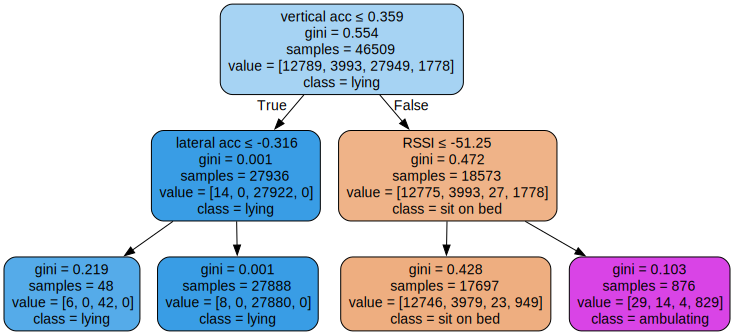

In [369]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=input_cols,
                                class_names=['sit on bed','sit on chair','lying','ambulating'],
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [370]:
# print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
# print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

In [371]:
all_models = []

In [372]:
# Bagging ensemble of decision trees
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [373]:
# Implement bagging prediction 
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()
    
    return combined_predictions

In [374]:
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import BaggingClassifier

error_rates = []
model_range = range(1, 11)

for model in model_range:
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=model,
        random_state=42
    ).fit(X_tr, y_tr)
    y_pred = bagging_clf.predict(X_test)
    error_rate = zero_one_loss(y_test, y_pred)
    error_rates.append(error_rate)

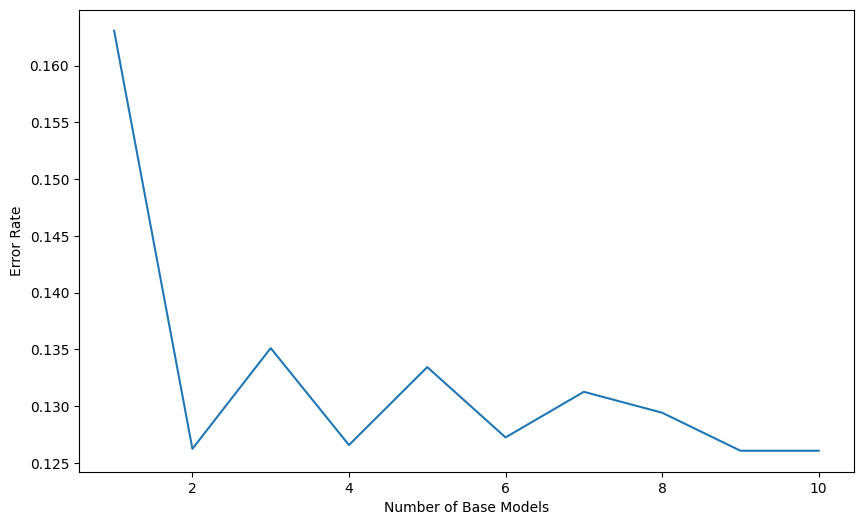

In [375]:
plt.figure(figsize=(10, 6))
plt.plot(model_range, error_rates)
plt.xlabel('Number of Base Models')
plt.ylabel('Error Rate')
plt.show()

In [376]:
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # TODO
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # TODO
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

In [377]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()
    
    return combined_predictions

In [378]:
# accuracy = model.score(X_test, y_test)
# print("Accuracy for a single model: {:.3f}".format(accuracy))

In [379]:
# prediction = bagging_predict(X_test, all_models)
# accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
# print("Test set accuracy: {}".format(accuracy))

In [380]:
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import BaggingClassifier

error_rates = []
base_error_rates = []

accuracy_bagging = []
accuracy_decision_tree = []

num_models = range(1, 41)

for models in num_models:
        bagging_clf = BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            n_estimators=models
        ).fit(X_tr, y_tr)

        accuracy_bagging.append(bagging_clf.score(X_test, y_test))

        y_pred = bagging_clf.predict(X_test)
        error_rate = zero_one_loss(y_test, y_pred)
        error_rates.append(error_rate)

for _ in num_models:
    base_model = DecisionTreeClassifier(random_state=42)
    base_model.fit(X_tr, y_tr)

    accuracy_decision_tree.append(base_model.score(X_test, y_test))

    y_pred = base_model.predict(X_test)
    error_rate = zero_one_loss(y_test, y_pred)
    base_error_rates.append(error_rate)

print()

In [381]:
print(round(np.mean(accuracy_decision_tree) ,2))
print( round(np.mean(accuracy_bagging),2) )

0.84
0.87


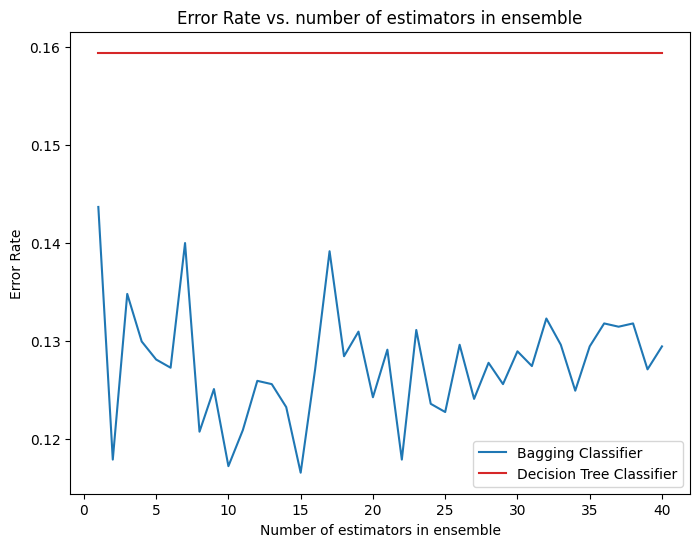

In [382]:
figure = plt.figure(figsize=(8, 6))

plt.plot(num_models, error_rates, c='tab:blue', label='Bagging Classifier')
plt.plot(num_models, base_error_rates, c='tab:red', label='Decision Tree Classifier')
plt.xlabel('Number of estimators in ensemble')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. number of estimators in ensemble')
plt.legend(loc='lower right')
plt.show()

In [383]:
# # 40
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharey=True)

# ax1.plot(num_models, error_rates, c='b', label='Bagging Model')

# # Plot error rates
# ax1.set_xlabel('Number of Base Models')
# ax1.set_ylabel('Error Rate')
# ax1.legend(loc='upper right')

# # Plot error rates
# ax2.plot(num_models, base_error_rates, c='r', label='Base Model')
# ax2.set_xlabel('Base Model Index')
# ax2.set_ylabel('Error Rate')
# # plt.title('Error Rate vs. Number of Base Models in Bagging')
# ax2.legend(loc='upper right')

In [384]:
model = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(),
                random_state=42
            ).fit(X_tr, y_tr)
            
print("Accuracy on training set: {:.3f}".format(model.score(X_tr, y_tr)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy on training set: 0.998
Accuracy on test set: 0.874


In [385]:
feature_sample_size = 200
max_depth_values = range(1, 21)
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
min_samples_split = range(2, 20)
min_samples_leaf = range(1, 10)
max_features = ['sqrt', 'log2']
min_impurity_decrease = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [386]:
feature_sample_size = 200
max_depth_values = range(1, 21)
criterion_values = ['gini', 'entropy', 'log_loss']
splitter_values = ['best', 'random']
min_samples_split_values = range(2, 20)
max_features_values = ['sqrt', 'log2']
min_impurity_decrease_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_leaf_values = range(1, 10)
max_leaf_nodes_values = range(2, 40)

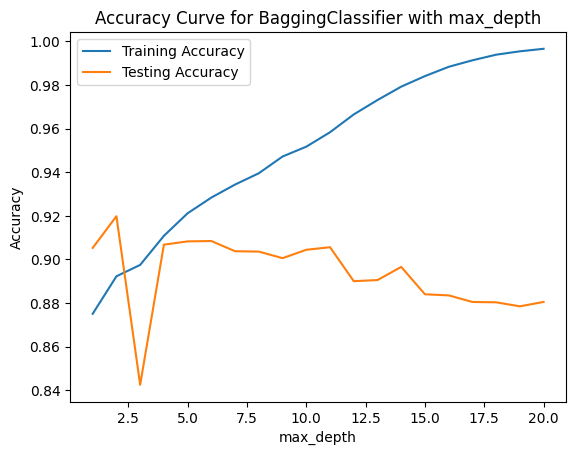

In [387]:
train_accuracy = []
test_accuracy = []

for max_d in max_depth_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  max_depth=max_d,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

plt.plot(max_depth_values, train_accuracy, label='Training Accuracy')
plt.plot(max_depth_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with max_depth')
plt.legend()
plt.show()

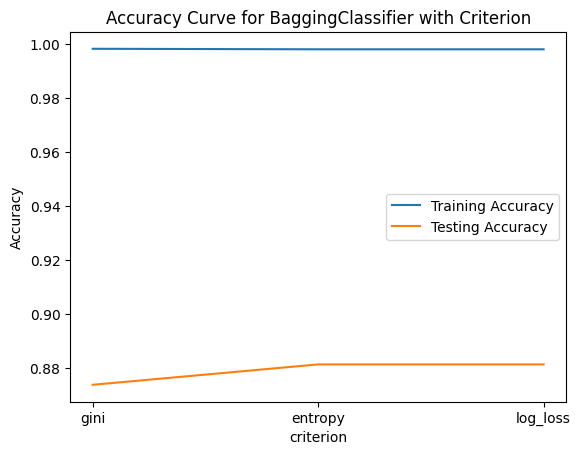

In [388]:
train_accuracy = []
test_accuracy = []

for c in criterion:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  criterion=c,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

plt.plot(criterion, train_accuracy, label='Training Accuracy')
plt.plot(criterion, test_accuracy, label='Testing Accuracy', c='tab:orange')
plt.xlabel('criterion')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with Criterion')
plt.legend()
plt.show()

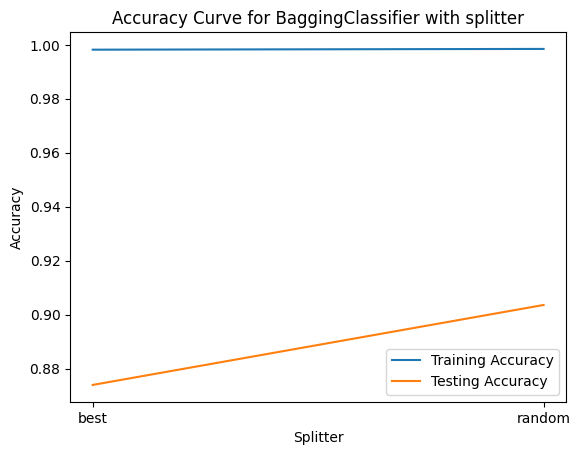

In [389]:
train_accuracy = []
test_accuracy = []

for s in splitter_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  splitter=s,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))

plt.plot(splitter_values, train_accuracy, label='Training Accuracy')
plt.plot(splitter_values, test_accuracy, label='Testing Accuracy', c='tab:orange')
plt.xlabel('Splitter')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with splitter')
plt.legend()
plt.show()

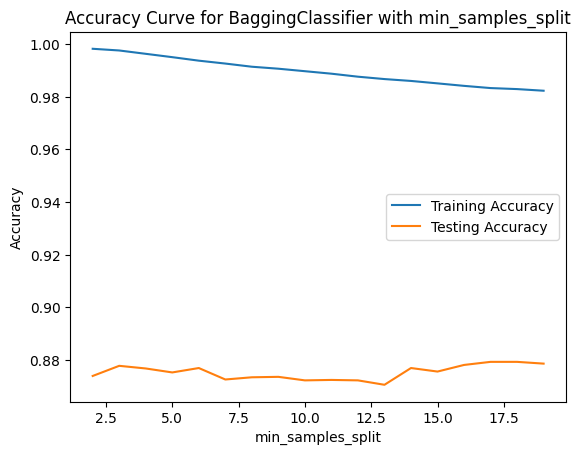

In [390]:
train_accuracy = []
test_accuracy = []

for mss in min_samples_split_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  min_samples_split=mss,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(min_samples_split_values, train_accuracy, label='Training Accuracy')
plt.plot(min_samples_split_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with min_samples_split')
plt.legend()
plt.show()

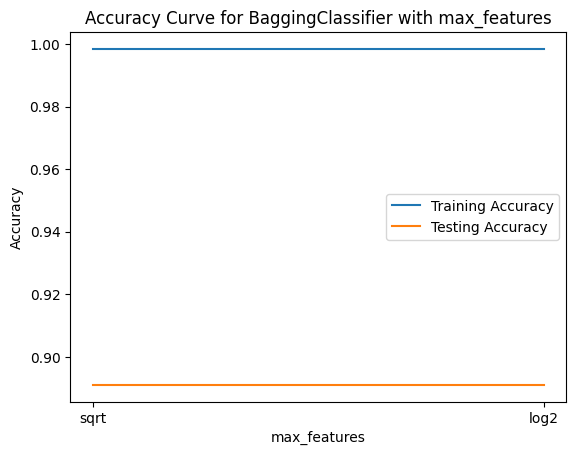

In [391]:
train_accuracy = []
test_accuracy = []

for f in max_features_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  max_features=f,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(max_features_values, train_accuracy, label='Training Accuracy')
plt.plot(max_features_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with max_features')
plt.legend()
plt.show()

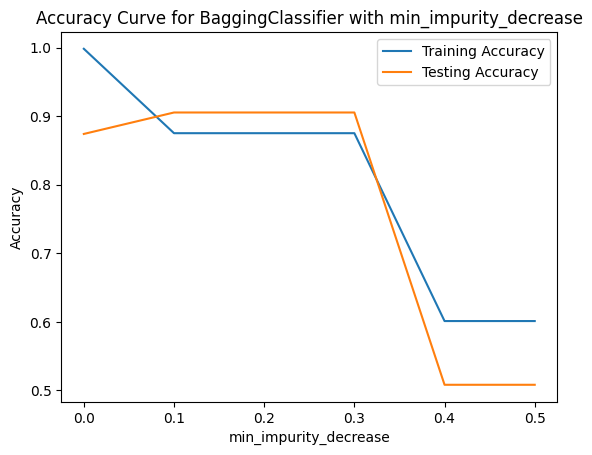

In [392]:
train_accuracy = []
test_accuracy = []

for impurity in min_impurity_decrease_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  min_impurity_decrease=impurity,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(min_impurity_decrease_values, train_accuracy, label='Training Accuracy')
plt.plot(min_impurity_decrease_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('min_impurity_decrease')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with min_impurity_decrease')
plt.legend()
plt.show()

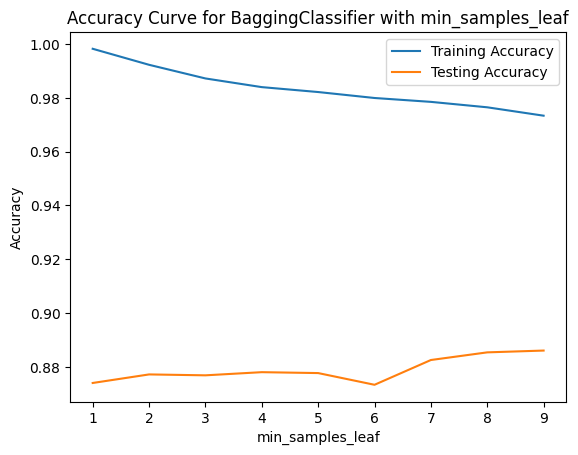

In [393]:
train_accuracy = []
test_accuracy = []

for min_samples in min_samples_leaf_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  min_samples_leaf=min_samples,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(min_samples_leaf_values, train_accuracy, label='Training Accuracy')
plt.plot(min_samples_leaf_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with min_samples_leaf')
plt.legend()
plt.show()

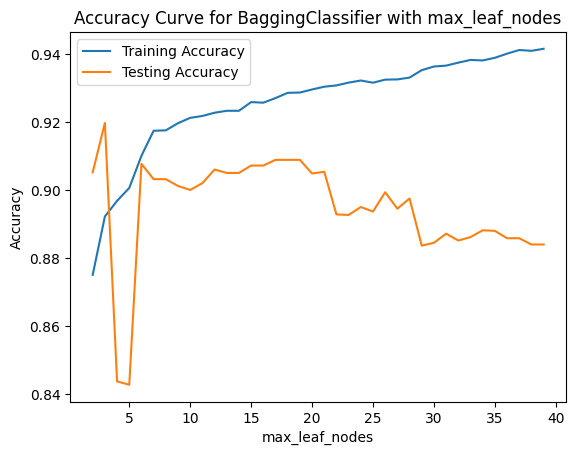

In [394]:
train_accuracy = []
test_accuracy = []

for max_leaf in max_leaf_nodes_values:
    model = BaggingClassifier(
                estimator=DecisionTreeClassifier(
                  max_leaf_nodes=max_leaf,
                  random_state=42
                ),
                random_state=42
            ).fit(X_tr, y_tr)
    train_accuracy.append(model.score(X_tr, y_tr))
    test_accuracy.append(model.score(X_test, y_test))
  
plt.plot(max_leaf_nodes_values, train_accuracy, label='Training Accuracy')
plt.plot(max_leaf_nodes_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for BaggingClassifier with max_leaf_nodes')
plt.legend()
plt.show()

In [395]:
feature_sample_size = 200
max_depth_values = range(1, 21)
criterion_values = ['gini', 'entropy', 'log_loss']
splitter_values = ['best', 'random']
min_samples_split_values = range(2, 20)
max_features_values = ['sqrt', 'log2']
min_impurity_decrease_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_leaf_values = range(1, 10)
max_leaf_nodes_values = range(2, 40)

In [396]:
param_grid = {
    "estimator__max_depth": list(range(1, 21)), 
    "estimator__criterion": ['gini', 'entropy', 'log_loss'],
    "estimator__splitter": ['best', 'random'],
    "estimator__min_samples_split": list(range(2, 20)), 
    "estimator__max_features":  ['sqrt', 'log2'],
    "estimator__min_impurity_decrease":[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "estimator__min_samples_leaf": list(range(1, 10)), 
    "estimator__max_leaf_nodes": range(2, 40),

}

clf = RandomizedSearchCV(BaggingClassifier(DecisionTreeClassifier(), random_state=42),
                         param_grid,
                         n_jobs=-1,     
                         verbose=3, 
                         random_state=42)                                 

In [397]:
clf.fit(X_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                               random_state=42),
                   n_jobs=-1,
                   param_distributions={'estimator__criterion': ['gini',
                                                                 'entropy',
                                                                 'log_loss'],
                                        'estimator__max_depth': [1, 2, 3, 4, 5,
                                                                 6, 7, 8, 9, 10,
                                                                 11, 12, 13, 14,
                                                                 15, 16, 17, 18,
                                                                 19, 20],
                                        'estimator__max_features': ['sqrt',
                                                                    'log2'],
                                        'estimator__max_leaf_nodes': range(2, 40),
                                        'estimator__min_impurity_decrease': [0.0,
                                                                             0.1,
                                                                             0.2,
                                                                             0.3,
                                                                             0.4,
                                                                             0.5],
                                        'estimator__min_samples_leaf': [1, 2, 3,
                                                                        4, 5, 6,
                                                                        7, 8,
                                                                        9],
                                        'estimator__min_samples_split': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18,
                                                                         19],
                                        'estimator__splitter': ['best',
                                                                'random']},
                   random_state=42, verbose=3)

In [398]:
print('Training accuracy: ', clf.score(X_tr, y_tr))
print('Testing accuracy: ', clf.score(X_test, y_test))

Training accuracy:  0.9191339310671053
Testing accuracy:  0.901724426586305


In [399]:
clf.best_params_

{'estimator__splitter': 'best',
 'estimator__min_samples_split': 8,
 'estimator__min_samples_leaf': 5,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__max_leaf_nodes': 11,
 'estimator__max_features': 'sqrt',
 'estimator__max_depth': 11,
 'estimator__criterion': 'log_loss'}